In [1]:
import numpy as np
import pygrib as pg
import json
import pathlib
import matplotlib.pyplot as plt
import shapely.geometry as sg

In [13]:
#ndfd_string = '../../../sampleinputs/torn_day1_grib2_1630_20190520162619'
ndfd_string = '/Users/josephpicca/Downloads/LEUZ98_KWNS_202101051740'
ndfd_file = pathlib.Path(ndfd_string) 

In [14]:
type(ndfd_file.as_posix())

str

In [15]:
with pg.open(ndfd_file.as_posix()) as GRB:
    try:
        vals = GRB[1].values.filled(-1)
    except AttributeError:
        vals = GRB[1].values
        
    lats,lons = GRB[1].latlons()

In [16]:
vals

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

### Get contours from ndfd grid

/Users/josephpicca/anaconda/envs/impacts/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  


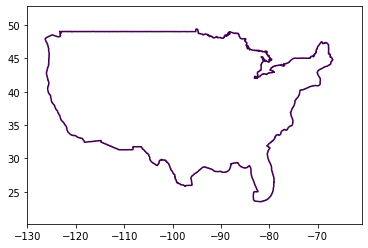

In [17]:
levels = [1.9999, 4.9999, 9.9999, 14.9999, 29.9999, 44.9999, 59.9999]
c = plt.contour(lons,lats,vals,levels=levels)

## Make geojson

In [40]:
geojson = {"type": "FeatureCollection", "features": []}

Make contour_to_geojson function

In [119]:
def formatGeoJson(level,coords):
     return {
        'type': 'Feature',
        'properties': {
            'probability': float('{:.2f}'.format(level))
        },
        'geometry': {
            'coordinates': [coords],
            'type': 'Polygon'
        }
     }

In [120]:
def contours_to_geojson(contours):
    
    # Instantiate geojson 'object'
    geojson = {"type": "FeatureCollection", "features": []}
    
    # What does this do?
    j2 = 0
    
    # Loop through each probability level
    for i,level in enumerate(contours.levels):
        
        # Get paths for each probability level
        paths = contours.collections[i].get_paths()
        
        # Loop through individual path lines of each probability level
        for path in paths:
            
            j2 += 1
            
            # Get shapely polygon object from path vertices
            poly = sg.Polygon(path.vertices)
            
            coords = []
            
            if poly.geom_type == 'MultiPolygon':
                
                for singlePoly in poly:
                    
                    if len(list(singlePoly.interiors)) > 0:
                        print('uh oh, hole in poly')
                    
                    for pair in singlePoly.exterior.coords:
                        coords.append(list(pair))
                        
                    json = formatGeoJson(level,coords)
                    
                    geojson['features'].append(json)
            
            elif poly.geom_type == 'Polygon':
                if len(list(poly.interiors)) > 0:
                    print('uh oh, hole in poly')
                
                for pair in poly.exterior.coords:
                    coords.append(list(pair))
                    
                json = formatGeoJson(level,coords)
                
                geojson['features'].append(json)
                
    return str(geojson).replace("'",'"')
            

In [121]:
geoStr = contours_to_geojson(c)

In [122]:
f = open('test.geojson', 'w')
f.write(geoStr)
f.close()

### Messing around

In [66]:
testPath = c.collections[1].get_paths()[0]
poly = sg.Polygon(testPath.vertices)

In [87]:
for level in c.levels:
    print('{:.2f}'.format(level))

2.00
5.00
10.00
15.00
30.00
45.00
60.00


OSError: oof